In [10]:
import sys
sys.path.insert(0,'../code/')
from  sir import *
plot_style(fs=14)

# Simple continuous SIR model (the almost vanilla SIR model)
Subpopulations: <br>
S = susceptible <br>
I = infected <br>
R = recovered <br>

This is the vanilla SIR (continuous, compartment, concentration, ...) model. <br>
The average rate ($\lambda_x$) of subpopulations change by a set of three ODEs. <br>
(Note the dynamics are not noisy, stochastic. However noise is placed in the observation model.)

\begin{eqnarray}
\dot{\lambda}_S &=& -\kappa_I \lambda_S \lambda_I\\
\dot{\lambda}_I &=& \kappa_I \lambda_S \lambda_I - \kappa_R \lambda_I \\
\dot{\lambda}_R &=& \kappa_R \lambda_R 
\end{eqnarray}

There is noisy observation model. Traditionally, this is a Poisson model 

\begin{eqnarray}
I\text{(day=i)} \sim \text{Poisson}(\lambda_I)
\end{eqnarray}

However, actual data can be much noisier and better fit by an over-dispersion model such as a Negative Binomial
\begin{eqnarray}
I\text{(day=i)} \sim \text{NegBinomial}(\lambda_I,\phi) \\
\text{where } \mathbb{E}(I\text{(day=i)}) =  \lambda_I \text{, and  Var}(I\text{(day=i)}) = \lambda_I + \frac{\lambda_I^2}{\phi}
\end{eqnarray}
This approaches Poisson in the limit $\phi \rightarrow \infty$ <br>
Running the toy model will give a better intuition for this modification. <br>
Here we assume infected, cases, are observed and fit that data.<br>
Our paper for COVID-19 modeling, analysis, has a number of permutations on this framework.<br>
These include adding an incubation period (using an additional compartment), mitigation measures, and using different types of data. <br>
These examples will be added later.

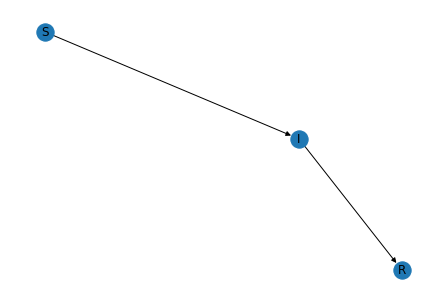

In [11]:
G = nx.DiGraph()
G.add_node('S')
G.add_node('I')
G.add_node('R')
G.add_edges_from([('S','I'),('I','R')])
nx.draw(G,with_labels=True)

In [6]:
scode_SIR_gen = """
functions{
  real[] SIR(real t,  // time
            real[] ln_init,// system state {infected,cases,susceptible}
            real[] theta,
            real[] x_r,
            int[] x_i)

    {
        real dy_dt[3];

        real kI = theta[1];
        real kR = theta[2];
        real lS = ln_init[1];  # susceptible
        real lI = ln_init[2];  # infected
        real lR = ln_init[3];  # recovered

        dy_dt[1] = -kI*lS*lI; //dS
        dy_dt[2] = kI*lS*lI - kR*lI; //dI
        dy_dt[3] = kR*lR; //dR
        return dy_dt;
    }
}

data {
    int<lower=1> Nsusc; //number that are susceptible (the effective population of interest)
    int<lower = 1> nobs; // number of days observed
    real t[nobs];
    real kI;
    real kR;
    real<lower=0, upper=1> S0; //normalized 0-1
    real phi; //inflation factor for Poisson variance
}
transformed data {
  real x_r[0];
  int x_i[0];
  }
generated quantities{
  real theta[2]; 
  real ln_init[3]; // 
  real ln[nobs,3]; // Nsusc normalized rates
  real I[nobs];
 
  theta[1] = kI;
  theta[2] = kR;
  
  ln_init[1] = S0;//S0, initial susceptible, S>0 and I>0, and S + I = 1 
  ln_init[2] = 1-S0;//I0, initial infected
  ln_init[3] = 0.0;//R0, no one recovered
  
  ln = integrate_ode_rk45(SIR, ln_init, t[1]-1, t, theta, x_r, x_i);
  
#   for (i in 1:nobs) {
#     I[i] = poisson_rng(ln[i, 2] * Nsusc); // lnS + lnI = 1 (norm fractions of pop), need to rescale
#   }

  for (i in 1:nobs) {
    I[i] = neg_binomial_2_rng(ln[i, 2] * Nsusc, phi); // lnS + lnI = 1 (norm fractions of pop), need to rescale
  }
    }
"""

modelname = 'scode_SIR_gen.stan'
f = open("./stan/"+modelname,'w')
f.write(scode_SIR_gen)
f.close()

In [85]:
scode_SIR_infer = """
functions{
  real[] SIR(real t,  // time
            real[] ln_init,// system state {infected,cases,susceptible}
            real[] theta,
            real[] x_r,
            int[] x_i)

    {
        real dy_dt[3];

        real kI = theta[1];
        real kR = theta[2];
        real lS = ln_init[1];  # susceptible
        real lI = ln_init[2];  # infected
        real lR = ln_init[3];  # recovered

        dy_dt[1] = -kI*lS*lI; //dS
        dy_dt[2] = kI*lS*lI - kR*lI; //dI
        dy_dt[3] = kR*lR; //dR
        return dy_dt;
    }
}

data {
    int<lower=1> Nsusc; //number that are susceptible (the effective population of interest)
    int<lower = 1> nobs; // number of days observed
    real t[nobs];
    int I[nobs];
}

transformed data {
  real x_r[0];
  int x_i[0];
  }

parameters{
    real<lower = 0> theta[2]; // model parameters 
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
    real phi;
  }

transformed parameters{
    real ln[nobs,3]; // solution from the ODE solver
    real ln_init[3];     // initial conditions for fractions

    ln_init[1] = S0; //S, ODE system is Nsusc normalized
    ln_init[2] = 1-S0;//1/Nsusc; //I
    ln_init[3] = 0; //R

    ln = integrate_ode_rk45(SIR, ln_init, t[1]-1, t, theta, x_r, x_i);
  }

model{
    //priors
    S0 ~ beta(2, 2); //some prior for between 0 and 1 fraction of the population
    for (i in 1:2){
        theta[i] ~ lognormal(0,1);
    }

    //likelihood
    for (i in 1:nobs){
        # target += poisson_lpmf(I[i]|ln[i,2]*Nsusc);  # I
        target += neg_binomial_2_lpmf(I[i]|ln[i, 2] * Nsusc, phi);
        }
  }

"""

modelname = 'scode_SIR_infer.stan'
f = open("./stan/"+modelname,'w')
f.write(scode_SIR_infer)
f.close()

In [86]:
smodel_gen = CmdStanModel(stan_file="./stan/scode_SIR_gen.stan")
smodel_infer = CmdStanModel(stan_file="./stan/scode_SIR_infer.stan")

INFO:cmdstanpy:compiling stan program, exe file: /Users/sv54/Git/SIRexamples/notebooks/stan/scode_SIR_infer
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/sv54/Git/SIRexamples/notebooks/stan/scode_SIR_infer


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Text(0, 0.5, 'infected')

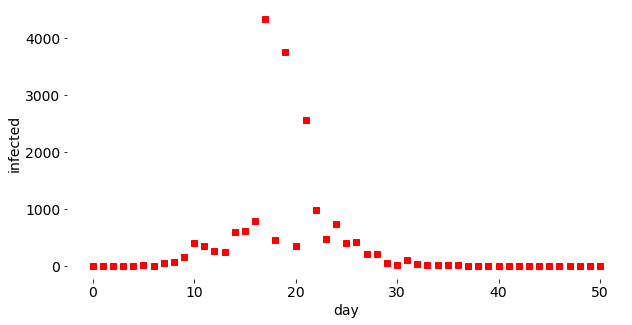

In [93]:
# data {
#     int<lower=1> Nsusc; //number that are susceptible (the effective population of interest)
#     int<lower = 1> nobs; // number of days observed
#     real t[nobs];
#     real kI;
#     real kR;
# }

t = list(np.arange(0,50+1))
Nsusc = 10000
I0 = 1/Nsusc #set analysis to when one case is observed
S0 = 1 - I0
phi = 2
kI = 1.0
kR = 0.5

sdata = "{"+f"""
"Nsusc":{Nsusc},
"nobs" : {len(t)},
"t" : {t},
"kI" : {kI},
"kR" : {kR},
"S0" : {S0},
"phi" : {phi}
"""+"}"

f = open('./syntheticdata/sdata_SIR_gen.json','w')
f.write(sdata)
f.close()

fit = smodel_gen.sample(data="./syntheticdata/sdata_SIR_gen.json",fixed_param=True,iter_sampling=1)
I = fit.stan_variable('I')[0,:]
fig = plt.figure(figsize=(10,5))
plt.plot(t,I,'rs')
plt.xlabel('day')
plt.ylabel('infected')


In [94]:
# data {
#     int<lower=1> Nsusc; //number that are susceptible (the effective population of interest)
#     int<lower = 1> nobs; // number of days observed
#     real t[nobs];
#     int I[nobs];
# }


sdata = "{"+f"""
"Nsusc":{Nsusc},
"nobs" : {len(t)},
"t" : {t},
"I" : {list(I.astype(int))}
"""+"}"

f = open('./syntheticdata/sdata_SIR_infer.json','w')
f.write(sdata)
f.close()


fit = smodel_infer.sample(data="./syntheticdata/sdata_SIR_infer.json",chains=1,iter_sampling=1000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


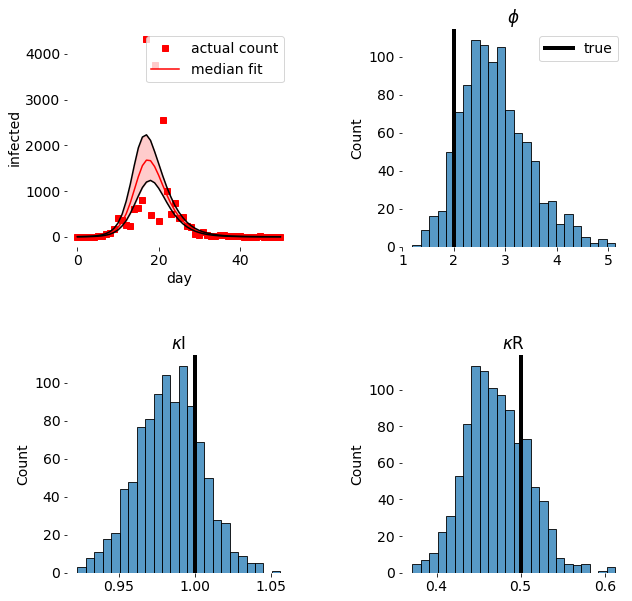

In [95]:
def get_dist(theta,a=None,ind=None):
    if a:
        theta = a*fit.stan_variable(theta)[:,:,ind].squeeze()
    else:
        theta = fit.stan_variable(theta)
    ub_ = np.quantile(theta,0.975,axis=0)
    m_ = np.quantile(theta,0.5,axis=0)
    lb_ = np.quantile(theta,0.025,axis=0)
    return ub_,m_,lb_

fig,ax = plt.subplots(2,2,figsize=(10,10))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
ub_,m_,lb_ = get_dist('ln',a=Nsusc,ind=1)
ax = ax.reshape(-1)
ax[0].plot(t,I,'rs',label='actual count')
ax[0].plot(t,m_,'r',label='median fit')
ax[0].set_ylabel('infected')
ax[0].set_xlabel('day')
ax[0].plot(t,ub_,'k')
ax[0].plot(t,lb_,'k')
ax[0].fill_between(x=t,y1=ub_,y2=lb_,color='r',alpha=0.2)
ax[0].legend()

x = fit.stan_variable('phi')
sns.histplot(x,ax=ax[1])
ax[1].set_title(r'$\phi$')
ax[1].axvline(phi,color='k',lw=4,label='true')
ax[1].legend()

x = fit.stan_variable('theta')[:,0]
sns.histplot(x,ax=ax[2])
ax[2].set_title(r'$\kappa$I')
ax[2].axvline(kI,color='k',lw=4,label='true')
# ax[2].legend()

x = fit.stan_variable('theta')[:,1]
sns.histplot(x,ax=ax[3])
ax[3].set_title(r'$\kappa$R')
ax[3].axvline(kR,color='k',lw=4,label='true')
# ax[3].legend()




In [96]:
print(fit.summary())



                  Mean          MCSE    StdDev          5%         50%  \
name                                                                     
lp__       -260.000000  7.200000e-02  1.400000 -270.000000 -260.000000   
theta[1]      0.980000  9.100000e-04  0.021000    0.950000    0.980000   
theta[2]      0.470000  1.700000e-03  0.037000    0.410000    0.470000   
S0            1.000000  0.000000e+00  0.000000    1.000000    1.000000   
phi           2.800000  0.000000e+00  0.700000    1.900000    2.700000   
...                ...           ...       ...         ...         ...   
ln[51,2]      0.000034  2.800000e-07  0.000008    0.000024    0.000033   
ln[51,3]      0.000000           NaN  0.000000    0.000000    0.000000   
ln_init[1]    1.000000  1.500000e-06  0.000033    1.000000    1.000000   
ln_init[2]    0.000086  1.500000e-06  0.000033    0.000043    0.000080   
ln_init[3]    0.000000           NaN  0.000000    0.000000    0.000000   

                   95%  N_Eff  N_Eff/